# Homework assignment №6

# Music Generation (with xLSTM)

In [1]:
# conda env create --name xlstm -f environment_pt260cu126.yaml
# conda activate xlstm
# pip install xlstm mido midi2audio

import time
import pickle
import csv

import torch
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

from mido import Message, MidiFile, MidiTrack

import numpy as np
from omegaconf import OmegaConf
from dacite import from_dict
from dacite import Config as DaciteConfig
from xlstm import xLSTMLMModel, xLSTMLMModelConfig
import numpy as np
from torch.nn import functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match device.type:
    case "cuda":
        print(f"Device: {torch.cuda.get_device_name()}")
    case "cpu":
        print("Device: CPU")

Device: NVIDIA GeForce RTX 4060


# Prepare the data

`chopin-notes` is a custom dataset that I collected a year ago for a side project.

In [2]:
with open("../data/chopin-notes", "rb") as f:
    notes: list[str] = pickle.load(f)

unique_notes = list(set(notes))
vocab_size = len(unique_notes)
print("Vocab size:", vocab_size)
note_to_idx = {note: i for i, note in enumerate(unique_notes)}
idx_to_note = {i: note for note, i in note_to_idx.items()}

Vocab size: 4289


In [3]:
class DataLoader:
    def __init__(self, B: int, L: int):
        """
        Dataloader to parse data in a format needed to train Large Language models.
        """
        self.B = B
        self.L = L

        ids = list(map(note_to_idx.get, notes))
        ids = torch.Tensor(ids).type(torch.long)

        self.tokens = ids
        self.current_position = 0

    def next_batch(self):
        B, L = self.B, self.L
        buf = self.tokens[self.current_position : self.current_position + B * L + 1]
        inputs = (buf[:-1]).view(B, L)
        targets = (buf[1:]).view(B, L)
        self.current_position += B * L

        if self.current_position + B * L < len(self.tokens):
            self.current_position = 0
        return inputs, targets

# Set up and train a model

In [ ]:
# Create a model
cfg = OmegaConf.load("xlstm_config.yaml")
cfg = from_dict(data_class=xLSTMLMModelConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
model = xLSTMLMModel(cfg);

In [5]:
# Print the size of the model (a number of parameters it has) in millions
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {num_params / 1e6:.2f}M")

Total Parameters: 0.15M


In [6]:
BATCH_SIZE: int = 32
CONTEXT_WINDOW: int = 512

dataloader = DataLoader(B=BATCH_SIZE, L=CONTEXT_WINDOW)

model.train()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), eps=1e-8, fused=True)
scheduler = CosineAnnealingLR(optimizer=optimizer, eta_min=1e-4, T_max=1000)

with open("training_logs.csv", mode="w", newline="", encoding="utf8") as file:
    writer = csv.writer(file)
    writer.writerow(["Step", "Loss", "Norm", "LR", "dt (ms)", "Tokens/sec"])

for step in tqdm(range(0, 2000)):
    model.train()
    t0 = time.time()

    optimizer.zero_grad()

    inputs, targets = dataloader.next_batch()
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        outputs = model(inputs)

    loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    tokens_processed =  dataloader.B * dataloader.L
    tokens_per_sec = tokens_processed / dt
    with open("training_logs.csv", mode="a", newline="", encoding="utf8") as file:
        writer = csv.writer(file)
        writer.writerow([step, f"{loss.item():.6f}", f"{norm:.4f}", f"{scheduler.get_last_lr()[0]:.4e}", f"{dt * 1000:.2f}", f"{tokens_per_sec:.2f}"])

torch.save(model.state_dict(), f"xlstm_cp_{step}.pth")

100%|██████████| 2000/2000 [02:21<00:00, 14.14it/s]


### Let's generate a song using the last `context_window` notes from the dataset
(the last sequence is used, because the model doesn't know how it continues)

In [7]:
def generate_text(model, notes_to_generate: int = 32, prompt: list[str] = ""):
    model.eval()
    ids = list(map(note_to_idx.get, prompt))
    ids = torch.Tensor(ids).type(torch.long).to(device).unsqueeze(0)
    generated_tokens = []

    for _ in range(notes_to_generate):
        with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = model(ids)[:, -1, :]
        next_token = torch.multinomial(F.softmax(logits, dim=-1), 1)
        generated_tokens.append(next_token.item())
        prompt = torch.cat((ids[:, 1:], torch.multinomial(F.softmax(logits, dim=-1), 1)), dim=1)

    return list(map(idx_to_note.get, generated_tokens))

generated_song = generate_text(model=model, notes_to_generate=512, prompt=notes[-CONTEXT_WINDOW:])

### Convert the generated notes (`str` objects) to the `.mid` format

In [8]:
NOTE_MAPPING = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
    'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
}

def note_to_midi(note):
    if note[-1].isdigit():
        pitch, octave = note[:-1], int(note[-1])
        return (octave + 1) * 12 + NOTE_MAPPING[pitch]
    return None

midi = MidiFile()
track = MidiTrack()
midi.tracks.append(track)
tempo = 120  # BPM
tick_duration = midi.ticks_per_beat // 4  # 16th note

for note_group in generated_song:
    note_list = note_group.split('.')
    midi_numbers = [note_to_midi(note) for note in note_list if note_to_midi(note) is not None]
    for midi_num in midi_numbers:
        track.append(Message('note_on', note=midi_num, velocity=64, time=0))
    for midi_num in midi_numbers:
        track.append(Message('note_off', note=midi_num, velocity=64, time=tick_duration))

midi_path = "generated_song.mid"
midi.save(midi_path)

## The file was converted to `.mp3` and attached to this repo.

# Listen to it -> `hw06/README.md`

Немного выводов/заметок:

1. Модель очень быстро переобучается, `embedding_dim >= 64` (300к+ параметров) приводит к нулевому лоссу.
2. При маленьком контекстом окне (до 128) модель выучивает генерить одну ноту (застривает в локальном минимуме).
3. Увеличение контекстного окна значительно улучшило генерацию.

# Mamba VS xLSTM

| Feature/Aspect                       |  xLSTM                                   |  Mamba                               |
|--------------------------------------|------------------------------------------|--------------------------------------|
| **Sound Smoothness**                 | ❌ Less smooth                          | ✅ More smooth                       |
| **Note Diversity**                   | ❌ Limited range of notes               | ✅ More diverse note generation      |
| **Ease of Hyperparameter Tuning**    | ❌ Requires meticulous tuning           | ✅ Easier to set up                  |
| **Training Stability**               | ✅ Stable                               | ✅ Stable                            |


------------------------------------------------------------------------------------

# Attention weights

- I changed the file `xlstm.blocks.mlstm.layer.mLSTMLayer` to compute and save attention weights.

In [9]:
def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:

    B, S, _ = x.shape

    # up-projection
    x_inner = self.proj_up(x)
    x_mlstm, z = torch.split(x_inner, split_size_or_sections=self.config._inner_embedding_dim, dim=-1)

    # mlstm branch
    x_mlstm_conv = self.conv1d(x_mlstm)
    x_mlstm_conv_act = self.conv_act_fn(x_mlstm_conv)

    q = self.q_proj(x_mlstm_conv_act)
    k = self.k_proj(x_mlstm_conv_act)
    v = self.v_proj(x_mlstm)

    # ==============================================================================
    attention_scores = torch.matmul(q, k.transpose(-2, -1))  # [batch_size, seq_len, seq_len]
    attention_weights = F.softmax(attention_scores, dim=-1)
    np.save("attention_weights", attention_weights.detach().cpu().numpy())
    # ==============================================================================

    h_tilde_state = self.mlstm_cell(q=q, k=k, v=v)

    h_tilde_state_skip = h_tilde_state + (self.learnable_skip * x_mlstm_conv_act)

    # output / z branch
    h_state = h_tilde_state_skip * self.ogate_act_fn(z)

    # down-projection
    y = self.dropout(self.proj_down(h_state))
    return y

from xlstm.blocks.mlstm.layer import mLSTMLayer

# Include attention weights computation
mLSTMLayer.forward = forward

In [10]:
# Inference the model to save the weights

generated_song = generate_text(model=model, notes_to_generate=512, prompt=notes[-CONTEXT_WINDOW:])

In [11]:
attention_weights = np.load("attention_weights.npy")

First 50 tokens


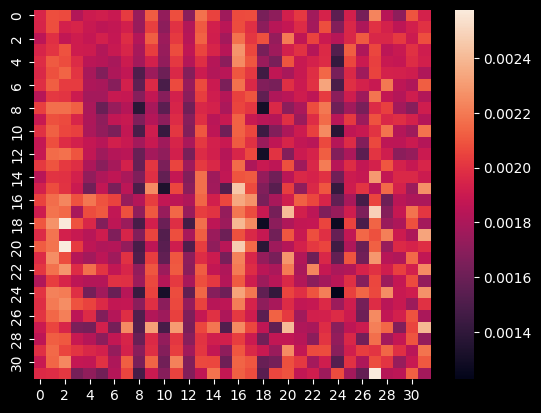

Last 50 tokens


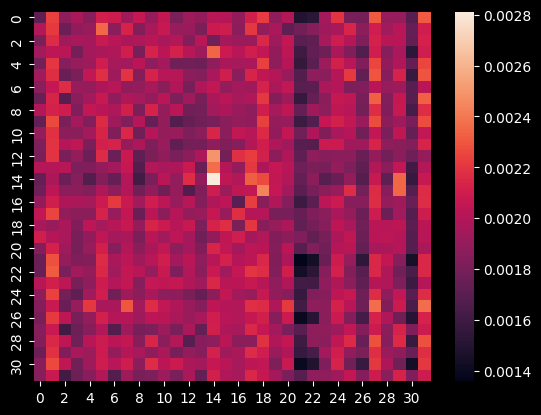

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

attention_weights = np.load("attention_weights.npy")
print("First 32 tokens")
sns.heatmap(attention_weights[0, :32, :32])
plt.show()

print("Last 32 tokens")
sns.heatmap(attention_weights[0, -32:, -32:])
plt.show()

# Полученные веса невозможно интерпретировать :(